In [20]:
import re
from datetime import datetime

In [21]:
import os
import geopandas as gpd
import geemap
import xml.etree.ElementTree as ET
import pandas as pd
from shapely.geometry import LineString

# constante requerida
namespace = {"kml": "http://www.opengis.net/kml/2.2"}

In [22]:
import geopandas as gpd
from pyproj import CRS
from pykml import parser
from shapely.geometry import Point, LineString

In [23]:
# Directorio donde están los archivos KML
path_kml = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\TLOGS\ALTA_03\Los_Andes_Parte_2'
contenido = os.listdir(path_kml)
len(contenido)

3

In [24]:
contenido

['Jul-31st-2024-05-17AM-Flight-Airdata.kml',
 'Jul-31st-2024-05-36AM-Flight-Airdata.kml',
 'Jul-31st-2024-05-46AM-Flight-Airdata.kml']

In [25]:
def extraer_fecha(fecha_txt):
    match = re.search(r"([A-Za-z]{3}-\d{1,2}[a-z]{2}-\d{4})", fecha_txt)
    return match.group(1) if match else None

def format_date(date_str):
    try:
        # Eliminar sufijos ordinales para facilitar la conversión
        date_without_suffix = re.sub(r'(st|nd|rd|th)', '', date_str)
        return pd.to_datetime(date_without_suffix, format='%b-%d-%Y').strftime('%d/%m/%Y')
    except:
        return None

def week_number(date_str):
    """
    Retorna el número de semana del año para una fecha dada en formato "dd/mm/aaaa".
    """
    try:
        date_obj = pd.to_datetime(date_str, format='%d/%m/%Y')
        return date_obj.isocalendar()[1]  # El segundo valor de isocalendar() es el número de semana
    except:
        return None

In [26]:
# lista para almacenar nombres de archivo
file_name = []
# lista para alamcenar recorridos
lineas = []

# itera sobre la lista de nombres de archivos
for i in contenido:
    # directorio + nombre de archivo
    path = path_kml + '\\' + i
    # leer el arbol de contenido del archivo
    tree = ET.parse(path)
    root = tree.getroot()
    for placemark in root.findall(".//kml:Placemark", namespace):
        coord_text = placemark.find(".//kml:coordinates", namespace).text.strip()
        # obtiene las cooredenadas
        coords = coord_text.split('\n')
        # lista para guardar las coors
        coordinates = []
        # recorre las coors
        for j in coords:
            # split para separa el 3er elemento que acompaña las coors
            coord = j.split(',')
            # agrega las coors a la lista
            coordinates.append((float(coord[0]), float(coord[1])))
    # conviente en DF
    df = pd.DataFrame(coordinates, columns=['Longitude', 'Latitude'])
    # convierte en GDF
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    # convierte el GDF en Linea
    line = LineString(gdf.geometry.tolist())
    # se almacena en listas el nombre del archivo y la geomedia del recorrido
    file_name.append(i)
    lineas.append(line)

In [30]:
# dic con la geometria y el file_name
data_lineas = {
    'nombre': file_name,
    'geometry': lineas
}

In [31]:
gdf_lineas = gpd.GeoDataFrame(data_lineas)

In [32]:
gdf_lineas.crs = "EPSG:4326"

In [33]:
gdf_lineas = gdf_lineas.to_crs(epsg=32720)

In [34]:
gdf_lineas

,nombre,geometry
0,Jul-31st-2024-05-17AM-Flight-Airdata.kml,"LINESTRING (480430.689 8089652.174, 480430.678..."
1,Jul-31st-2024-05-36AM-Flight-Airdata.kml,"LINESTRING (480431.858 8089652.020, 480431.848..."
2,Jul-31st-2024-05-46AM-Flight-Airdata.kml,"LINESTRING (480431.540 8089651.666, 480431.529..."


<Axes: >

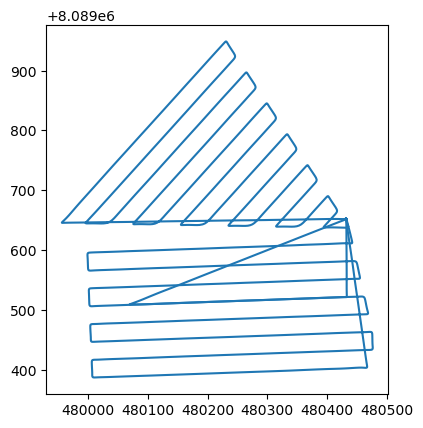

In [35]:
gdf_lineas.plot()

In [36]:
len(gdf_lineas)

3

In [37]:
gdf_lineas.to_file(path_kml + '\\capa_kml_todo.shp', driver="ESRI Shapefile")